## Convolutional Neural Network
   #### Computer Vision Winter Semester 2020/2021 by Clemens Spielvogel
    
Convolutional Neural Networks (CNNs) are variations of neural networks specifically made for computer vision tasks. Their main advantage over classical neural networks is the sparsity of connections and the sharing of parameters over different regions via the usage of convolutional filters.
The following code will demonstrate how to use Keras with Tensorflow backend for creating classification models for image data.

Installations (Ubuntu)
   * $ pip install plotly
   
Resources:
   * Tensorflow tutorials: https://www.tensorflow.org/tutorials/
   * Tensorflow guide: https://www.tensorflow.org/guide/
   * Tensorflow documentation: https://www.tensorflow.org/versions/r1.14/api_docs/python/tf
   * Keras documentation: https://keras.io/

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # If you want to use TF CPU version while having the GPU version installed

import tensorflow as tf
from keras import Sequential, layers, regularizers
import keras
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
import plotly.offline as ply
import plotly.graph_objs as graphs
import math
import random
import matplotlib.pyplot as plt

print("Keras version", keras.__version__)
print("TF version", tf.__version__)

Using TensorFlow backend.


Keras version 2.3.1
TF version 2.1.0


In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value) # Resets itself on every use!
tf.random.set_seed(seed_value) # tf.set_random_seed(seed_value) on older TF versions

In [3]:
def load_data(file_path):
    # Load CSV file to pandas data frame
    df = pd.read_csv(file_path, header=0)

    # Split data frame columns into features and labels
    y = df["label"].values
    X_flat = df.drop("label", axis=1).values
    X = [np.resize(array, (28, 28)) for array in X_flat] # Resize flat vector to 28x28
    X = np.array([np.reshape(sample, (sample.shape[0], sample.shape[1], 1)) for sample in X]) # Add color channel
    
    return X, keras.utils.to_categorical(y) # Labels are returned as one-hot encoded vectors

In [4]:
def plot_train_val_performances(performances, metric="Accuracy", show=True):
    """Plot training vs. validation accuracy over all epochs. performances is a dictionary mapping epoch numbers
       as integers to lists containing training and validation performance (e.g. accuracy).
       metric is a string indicating the used performance metric."""
    x = list(performances.keys())     # Number of epoch
    y_train = [i[0] for i in performances.values()]
    y_val = [i[1] for i in performances.values()]

    trace_train = graphs.Scatter(x=x, y=y_train, name="Training", mode="lines+markers",
                                 line=dict(width=4),
                                 marker=dict(symbol="circle",
                                             size=10))
    trace_val = graphs.Scatter(x=x, y=y_val, name="Validation", mode="lines+markers",
                                line=dict(width=4),
                                marker=dict(symbol="circle",
                                            size=10))

    layout = graphs.Layout(title="Training vs. Validation {}".format(metric),
                           xaxis={"title": "Epoch"},
                           yaxis={"title": metric})

    fig = graphs.Figure(data=[trace_train, trace_val], layout=layout)
    ply.plot(fig, filename="plotly_train_val_{}.html".format(metric), auto_open=show)
    print("Plot saved as plotly_train_val_{}.html".format(metric))

In [5]:
def create_2DCNN_model(input_shape):
    """Build architecture of the model"""
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape,
                            activation="relu", padding="same"))
    model.add(layers.Conv2D(64, (3, 3), activation="selu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation="selu", padding="same"))
    model.add(layers.Conv2D(64, (3, 3), activation="selu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="selu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="selu",
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="selu"))
    model.add(layers.Dense(10, activation="softmax"))

    # Create model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [6]:
# Specify data location
data_dir = r"Data\mnist.csv"

# Set hyperparameters
num_epochs = 20
batch_size = 64
dims = (28, 28, 1)

In [7]:
# Load data
X, y = load_data(data_dir)

# Determine split sizes (Could also be hardcoded)
train_size = math.floor(0.8 * len(y))
val_size = math.floor(0.1 * len(y))
test_size = math.floor(0.1 * len(y))

# Create splitted sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [8]:
# Create CNN model
model = create_2DCNN_model(dims)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)        

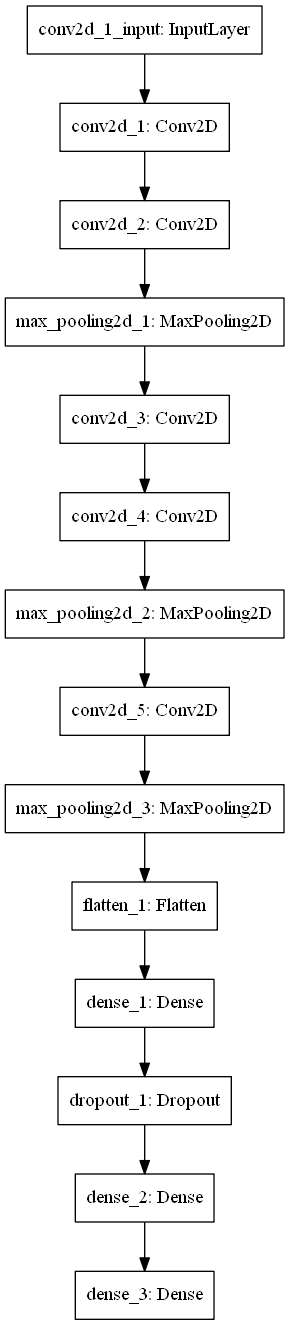

In [9]:
# Two possibilities to display specifications of your model
print(model.summary())
plot_model(model)

In [10]:
# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

In [11]:
# Train model
train_summary = model.fit(x=X_train,
                          y=y_train,
                          validation_data=(X_val, y_val),
                          batch_size=batch_size,
                          epochs=num_epochs,
                          callbacks=[callback],
                          verbose=1)

Train on 8000 samples, validate on 1000 samples
Epoch 1/20
8000/8000 [==============================] - 4s 535us/step - loss: 1.3336 - accuracy: 0.7006 - val_loss: 0.3147 - val_accuracy: 0.9360
Epoch 2/20
8000/8000 [==============================] - 3s 346us/step - loss: 0.3080 - accuracy: 0.9369 - val_loss: 0.1548 - val_accuracy: 0.9800
Epoch 3/20
8000/8000 [==============================] - 3s 350us/step - loss: 0.2194 - accuracy: 0.9620 - val_loss: 0.1474 - val_accuracy: 0.9860
Epoch 4/20
8000/8000 [==============================] - 3s 353us/step - loss: 0.1650 - accuracy: 0.9783 - val_loss: 0.1334 - val_accuracy: 0.9900
Epoch 5/20
8000/8000 [==============================] - 3s 350us/step - loss: 0.1480 - accuracy: 0.9833 - val_loss: 0.1241 - val_accuracy: 0.9900
Epoch 6/20
8000/8000 [==============================] - 3s 349us/step - loss: 0.1398 - accuracy: 0.9839 - val_loss: 0.1062 - val_accuracy: 0.9930
Epoch 7/20
8000/8000 [==============================] - 3s 350us/step - loss

In [12]:
# Evaluate fitted model using test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("\nTest ACC:", round(test_acc, 3))

1000/1000 [==============================] - 0s 320us/step

Test ACC: 0.986


In [13]:
# Get epochwise performances
train_acc = train_summary.history["accuracy"]
val_acc = train_summary.history["val_accuracy"]

# Format and store performances per epoch for plotting
accs = {epoch: [round(performance[0], 2), round(performance[1], 2)]
        for epoch, performance in enumerate(zip(train_acc, val_acc))}

# Plot training and validation performance over epochs
plot_train_val_performances(accs, "Accuracy")

Plot saved as plotly_train_val_Accuracy.html


In [14]:
# Save model
model.save_weights("model_weights.h5")